# NIRCam PSF Photometry - Basic Example on stage-2 images

**Author**: Matteo Correnti, STScI Scientist II
<br>
**Last Updated**: June, 2021

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Plotting functions imports](#matpl_imports)<br>
    2.3 [PSF FWHM dictionary](#psf_fwhm)<br>
3. [Import image to analyze](#data)<br>
    3.1 [Display image](#display_data)<br>
    3.2 [Convert image units and apply pixel area map](#convert_data)<br>
4. [Create a synthetic PSF model (with WebbPSF)](#webbpsf_intro)<br>
    4.1 [Create the single PSF](#single_webbpsf)<br>
    4.2 [Display the single PSF](#display_single_webbpsf)<br>
    4.3 [Create the grid of PSFs](#grid_webbpsf)<br>
    4.4 [Display the grid of PSFs](#display_grid_webbpsf)<br>
5. [Create the PSF model building an effective PSF](#epsf_intro)<br>
    5.1 [Calculate the background](#bkg)<br>
    5.2 [Find sources in the image](#find)<br>
    5.3 [Select sources](#select)<br>
    5.4 [Create catalog of selected sources](#create_cat)<br>
    5.5 [Build the effective PSF](#build_epsf)<br>
    5.6 [Display the effective PSF](#display_epsf)<br>
6. [Perform PSF Photometry](#psf_phot)<br>
    6.1 [PSF photometry output catalog](#psf_cat)<br>
    6.2 [Display residual images](#residual)<br>
7. [Bonus Part I: create your first NIRCam Color-Magnitude Diagram](#bonusI)<br>
    7.1 [Load images and output catalogs](#load_data)<br>
    7.2 [Cross-match PSF photometry catalogs](#cross_match)<br>
    7.3 [Load input catalogs](#load_input)<br>
    7.4 [Cross-match input catalogs](#cross_match_input)<br>
    7.5 [Instrumental Color-Magnitude Diagram](#cmd)<br>
8. [Bonus part II: create a grid of empirical PSFs](#bonusII)<br>
    8.1 [Count stars in N x N grid](#count_stars)<br>
    8.2 [Build effective PSF (single or grid)](#epsf_grid)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Data**: NIRCam simulated images obtained using [MIRAGE](https://jwst-docs.stsci.edu/jwst-other-tools/mirage-data-simulator) and run through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/) of the Large Magellanic Cloud (LMC) Astrometric Calibration Field. Simulations is obtained using a 4-pt subpixel dither for two couples of wide filters: F115W, and F200W for the SW channel, and F277W and F444W for the LW channel. We simulated only 1 NIRCam SW detector (i.e., "NRCB1"). 

For this example, we use 1 Level-2 images (.cal, calibrated but not rectified) for each of two SW filters (i.e., F115W and F200W) and derive the photometry in each one of them.

PSF Photometry can be obtained using:

* single PSF model obtained from WebbPSF
* grid of PSF models from WebbPSF
* single effective PSF (ePSF)
* grid of effective PSF (bonus part II)

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PSF photometry on the image
* how to cross-match the catalogs of the different images (bonus part I)

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we import all the necessary python packages and we define some plotting parameters

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
import os

os.environ['WEBBPSF_PATH'] = "/grp/jwst/ote/webbpsf-data"
# os.environ['WEBBPSF_PATH'] = '/data/webbpsf-data'

import sys
import time

import numpy as np

import pandas as pd

import glob as glob

import urllib.request

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils.detection import DAOStarFinder
from photutils import EPSFBuilder, GriddedPSFModel
from photutils.psf import DAOGroup, extract_stars, IterativelySubtractedPSFPhotometry

import jwst
from jwst.datamodels import ImageModel

import webbpsf
from webbpsf.utils import to_griddedpsfmodel

import pysynphot  # PYSIN_CDBS must be defined in the user's environment (see note below)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-036
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


<div class="alert alert-block alert-info">

**Note on pysynphot**: Data files for pysynphot are distributed separately by Calibration Reference Data System. They are expected to follow a certain directory structure under the root directory, identified by the PYSYN_CDBS environment variable that must be set prior to using this package. In the example below, the root directory is arbitrarily named /my/local/dir/trds/. \
export PYSYN_CDBS=/my/local/dir/trds/ \
See documentation [here](https://pysynphot.readthedocs.io/en/latest/#installation-and-setup) for the configuration and download of the data files.
    
<div >

### 2.2<font color='white'>-</font>Plotting function imports<a class="anchor" id="matpl_imports"></a> ###

In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

### 2.3<font color='white'>-</font>PSF FWHM dictionary<a class="anchor" id="psf_fwhm"></a> ###

The dictionary contains the NIRCam point spread function (PSF) FWHM, from the [NIRCam Point Spread Function](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions) JDox page. The FWHM are calculated from the analysis of the expected NIRCam PSFs simulated with [WebbPSF](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/psf-simulation-tool). 

**Note**: this dictionary will be updated once the values for the FWHM will be available for each detectors after commissioning.

In [3]:
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987, 1.103, 1.298, 1.553, 1.628, 1.770, 1.801, 1.494, 1.990, 2.060, 2.141, 2.304, 2.341, 1.340,
            1.444, 1.585, 1.547, 1.711, 1.760, 1.830, 1.901, 2.165, 2.179, 2.300, 2.302, 2.459, 2.507, 2.535, 2.574]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

3.<font color='white'>-</font>Import image to analyze<a class="anchor" id="data"></a>
------------------

**Note**: in this particular example, we analyze each image separately to provide a general overview of the different steps necessary to perform PSF photometry and to highlight the different functions adopted in this notebook.

We retrieve the NIRCam detector and filter from the image header. Note that for the LW channels, we transform the detector name derived from the header (**NRCBLONG**) to **NRCB5**. This will allow us to use the same variable name when creating a PSF using WebbPSF. 

In [6]:
# Download images from BOX if not already present in the directory:

if os.path.isfile('./jw00042001001_01101_00001_nrcb1_cal.fits'):
    image_f115w = './jw00042001001_01101_00001_nrcb1_cal.fits'

else:
    print('Downloading F115W image')
    
    boxlink_image_f115w = 'https://stsci.box.com/shared/static/oq98e11uvpv7x8zg69npk4w93n2odx8s.fits'
    boxfile_image_f115w = './jw00042001001_01101_00001_nrcb1_cal.fits'
    urllib.request.urlretrieve(boxlink_image_f115w, boxfile_image_f115w)
    image_f115w = boxfile_image_f115w
    
if os.path.isfile('./jw00042001001_01101_00005_nrcb1_cal.fits'):
    image_f200w = './jw00042001001_01101_00005_nrcb1_cal.fits'

else:

    print('Downloading F200W image')
    
    boxlink_image_f200w = 'https://stsci.box.com/shared/static/ai28kjn6s2jdjihepbwt2k0wl7ksqvyr.fits'
    boxfile_image_f200w = './jw00042001001_01101_00005_nrcb1_cal.fits'
    urllib.request.urlretrieve(boxlink_image_f200w, boxfile_image_f200w)
    image_f200w = boxfile_image_f200w

# Select image we want to analyze: 

image = image_f115w

im = fits.open(image)
f = im[0].header['FILTER']
d = im[0].header['DETECTOR']

if d == 'NRCBLONG':
    d = 'NRCB5'
elif d == 'NRCALONG':
    d = 'NRCA5'
else:
    d = d

det = d
filt = f 

print('Analyzed image detector:', det)
print('Analyzed image filter:', filt)

Analyzed image detector: NRCB1
Analyzed image filter: F115W


### 3.1<font color='white'>-</font>Display the image<a class="anchor" id="display_data"></a> ###

To check that our image does not present artifacts and can be used in the analysis, we display it. 

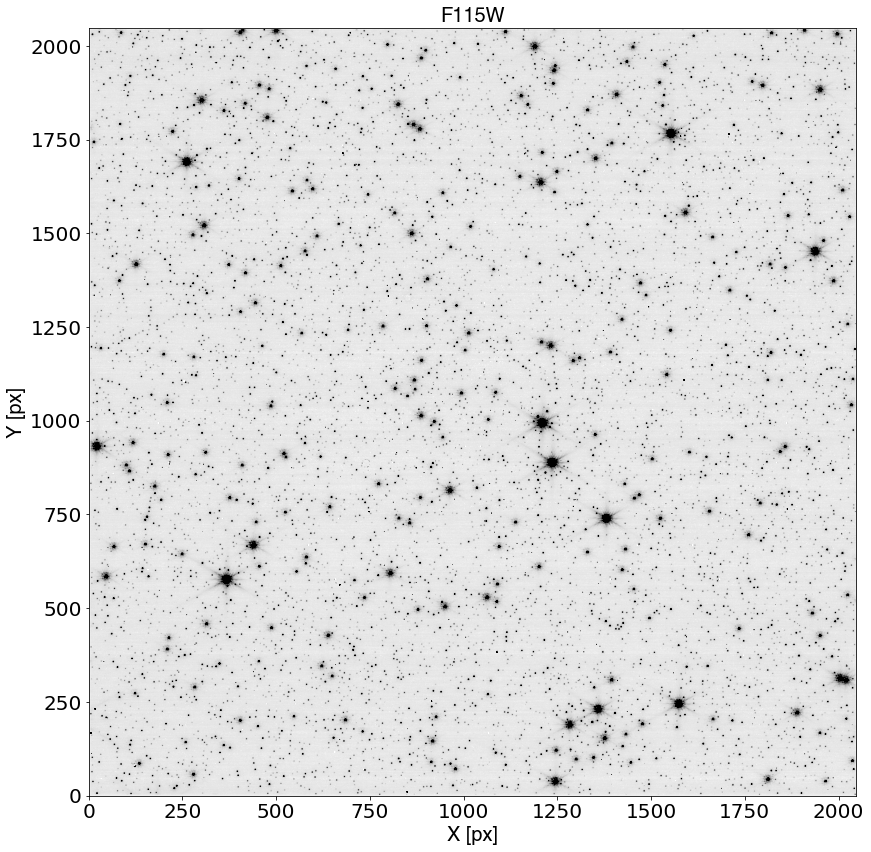

In [7]:
plt.figure(figsize=(12, 12))
   
data_sb = im[1].data

ax = plt.subplot(1, 1, 1)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title(filt, fontdict=font2)
norm = simple_norm(data_sb, 'sqrt', percent=99.)

ax.imshow(data_sb, norm=norm, cmap='Greys')

plt.tight_layout()

### 3.2<font color='white'>-</font>Convert image units and apply pixel area map<a class="anchor" id="convert_data"></a> ###

The unit of the Level-2 and Level-3 Images from the pipeline is MJy/sr (hence a surface brightness). The actual unit of the image can be checked from the header keyword **BUNIT**. The scalar conversion constant is copied to the header keyword **PHOTMJSR**, which gives the conversion from DN/s to megaJy/steradian. For our analysis we revert back to DN/s.

For images that have not been transformed into a distortion-free frame (i.e. not drizzled), a correction must be applied to accout for the different on-sky pixel size across the field of view. A pixel area map (PAM), which is an image where each pixel value describes that pixel's area on the sky relative to the native plate scale, is used for this correction. In the stage 2 of the JWST pipeline, the PAM is copied into an image extension called **AREA** in the science data product. 

In [8]:
imh = im[1].header
data = data_sb / imh['PHOTMJSR']
print('Conversion factor from {units} to DN/s for filter {f}:'.format(units=imh['BUNIT'], f=filt), imh['PHOTMJSR'])
area = im[4].data
data = data * area

Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127


4.<font color='white'>-</font>Create synthetic PSF (with WebbPSF) <a class="anchor" id="webbpsf_intro"></a>
------------------

WebbPSF is a Python package that computes simulated PSFs for NASA’s JWST and Nancy Grace Roman Space Telescope (formerly WFIRST). WebbPSF transforms models of telescope and instrument optical state into PSFs, taking into account detector pixel scales, rotations, filter profiles, and point source spectra. It is not a full optical model of JWST, but rather a tool for transforming optical path difference (OPD) maps, created with some other tool, into the resulting PSFs as observed with JWST’s or Roman’s instruments. For a full documentation on WebbPSF, see [here](https://webbpsf.readthedocs.io/en/latest/) and for is capability and limitation, see [here](https://webbpsf.readthedocs.io/en/latest/intro.html).

The function below allows to create a single PSF or a grid of PSFs (the PSF can also be saved as a fits file). First, we need to specify the instrument (NIRCam), detector, and filter. Then, to create a single (or grid) PSF we use the webbPSF method *psf_grid*, which will output a (list of or single) photutils GriddedPSFModel object(s). A tutorial notebook on the *psf_grid* method can be found [here](https://github.com/spacetelescope/webbpsf/blob/stable/notebooks/Gridded_PSF_Library.ipynb).

**Important Parameters**:

* `num`: The total number of fiducial PSFs to be created and saved in the files. This
    number must be a square number (4, 9, 16, etc.)

* `oversample`: the oversample factor we want to adopt in the PSF creation.

* `fov`: the size in pixel of the PSF model. The size depends on the shape of the PSF and how much flux is contained in the wings of the PSFs (i.e., a small field of view will exclude more flux from the PSF wings). However, increasing the field of view, increase also the computational time, so we need to find a reasonable compromise.

* `all_detectors`: run all detectors for the instrument. Since we analyze only 1 detector, we set `all_detectors = False` (we do not need to create a PSF model for all NIRCam detectors).

* `use_detsampled_psf`: If the grid of PSFs returned will be detector sampled (made by binning down the oversampled PSF) or oversampled by the factor defined by the oversample. For our analysis, we want to create an oversampled PSF model, so we set `use_detsampled_psf = False`.

<div class="alert alert-block alert-info">
    
**Note on centering**: by default, the PSF will be centered at the exact center of the output array. This means that if the PSF is computed on an array with an odd number of pixels, the PSF will be centered exactly on the central pixel. If the PSF is computed on an array with even size, it will be centered on the “crosshairs” at the intersection of the central four pixels.

**Note on normalization**: by default, PSFs are normalized to total intensity = 1.0 at the entrance pupil (i.e. at the JWST OTE primary). A PSF calculated for an infinite aperture would thus have integrated intensity =1.0. A PSF calculated on any smaller finite subarray will have some finite encircled energy less than one.

**Note on source spectrum**: The default source spectrum is, if *pysynphot* is installed, a G2V star spectrum from Castelli & Kurucz (2004). Without *pysynphot*, the default is a simple flat spectrum such that the same number of photons are detected at each wavelength.

</div>

In [24]:
def create_psf_model(det='NRCA1', filt='F070W', fov=11, create_grid=False, num=9, save_psf=False, detsampled=False):

    nrc = webbpsf.NIRCam()

    nrc.detector = det 
    nrc.filter = filt

    #src = webbpsf.specFromSpectralType('G5V', catalog='phoenix')
    
    print("Using a {field}".format(field=fov), "px fov")

    if create_grid:
        print("")
        print("Creating a grid of PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = num
        
        if save_psf:
            
            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            #psf = nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False, fov_pixels=fov, 
                     #save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, all_detectors=False, fov_pixels=fov, 
                     save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:
        
            #psf = nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False,
                                    #fov_pixels=fov, use_detsampled_psf=detsampled)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, all_detectors=False,
                                    fov_pixels=fov, use_detsampled_psf=detsampled)
            
    else:
        print("")
        print("Creating a single PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = 1
        
        if save_psf:

            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            #psf = nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False, fov_pixels=fov, 
                     #save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, all_detectors=False, fov_pixels=fov, 
                     save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)
        
        else:
      
            #psf = nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False,
                                      #fov_pixels=fov, use_detsampled_psf=detsampled)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, all_detectors=False,
                                      fov_pixels=fov, use_detsampled_psf=detsampled)
        
    return psf     

### 4.1<font color='white'>-</font>Create the single PSF<a class="anchor" id="single_webbpsf"></a> ###

In [27]:
psfs_dir = 'PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)

psf_webbpsf_single = create_psf_model(det=det, filt=filt, fov=11, create_grid=False, 
                                      num=16, save_psf=True, detsampled=False)

Using a 11 px fov

Creating a single PSF for filter F115W and detector NRCB1


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1
    Position 1/1: (1023, 1023) pixels
  Saving file: PSF_MODELS/PSF_F115W_samp4_fov11_npsfs1_nrcb1.fits


### 4.2<font color='white'>-</font>Display the single PSF<a class="anchor" id="display_single_webbpsf"></a> ###

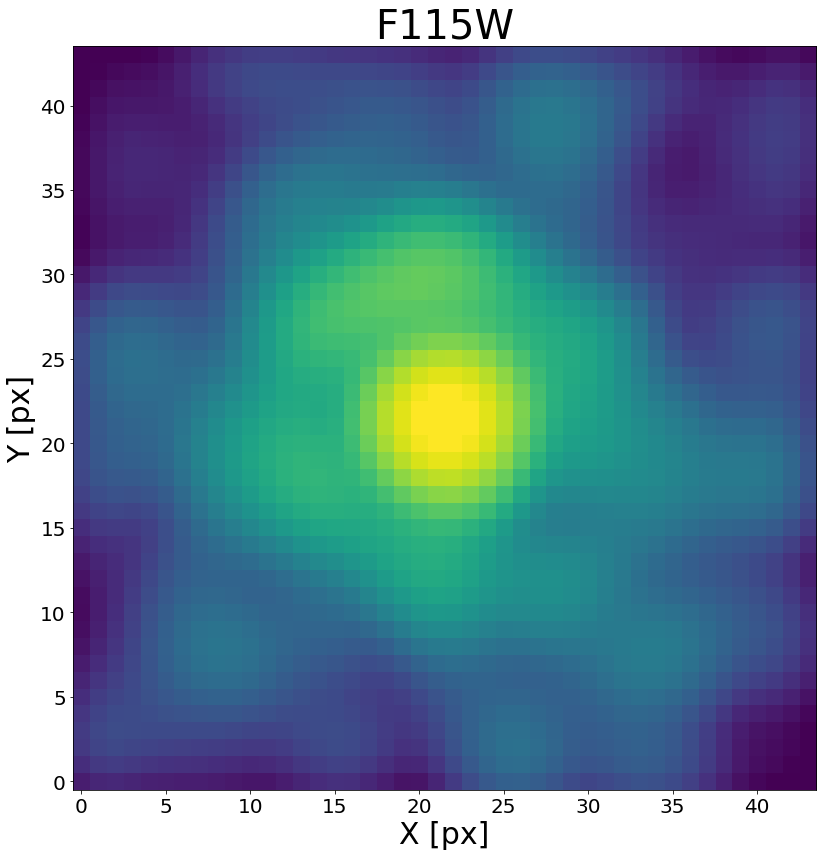

In [28]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(1, 1, 1)

norm_psf = simple_norm(psf_webbpsf_single.data[0], 'log', percent=99.)
ax.set_title(filt, fontsize=40)
ax.imshow(psf_webbpsf_single.data[0], norm=norm_psf)
ax.set_xlabel('X [px]', fontsize=30)
ax.set_ylabel('Y [px]', fontsize=30)
plt.tight_layout()

### 4.3<font color='white'>-</font>Create the grid of PSFs<a class="anchor" id="grid_webbpsf"></a> ###

In [29]:
psf_webbpsf_grid = create_psf_model(det=det, filt=filt, fov=11, create_grid=True, 
                                      num=16, save_psf=True, detsampled=False)

Using a 11 px fov

Creating a grid of PSF for filter F115W and detector NRCB1


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (682, 682) pixels
    Position 7/16: (682, 1365) pixels
    Position 8/16: (682, 2047) pixels
    Position 9/16: (1365, 0) pixels
    Position 10/16: (1365, 682) pixels
    Position 11/16: (1365, 1365) pixels
    Position 12/16: (1365, 2047) pixels
    Position 13/16: (2047, 0) pixels
    Position 14/16: (2047, 682) pixels
    Position 15/16: (2047, 1365) pixels
    Position 16/16: (2047, 2047) pixels
  Saving file: PSF_MODELS/PSF_F115W_samp4_fov11_npsfs16_nrcb1.fits


### 4.4<font color='white'>-</font>Display the grid of PSFs<a class="anchor" id="display_grid_webbpsf"></a> ###

We show the grid of PSFs with their positions in detector coordinates and the difference from the mean to highlight the differences between the different models. We use the webbPSF function *gridded_library.display_psf_grid*.

/Users/correnti/miniconda3/envs/mirage_dev/lib/python3.7/site-packages/webbpsf/gridded_library.py:511: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axes[n-1-iy, ix].imshow(data[i], vmax=vmax, vmin=vmin, norm=norm)


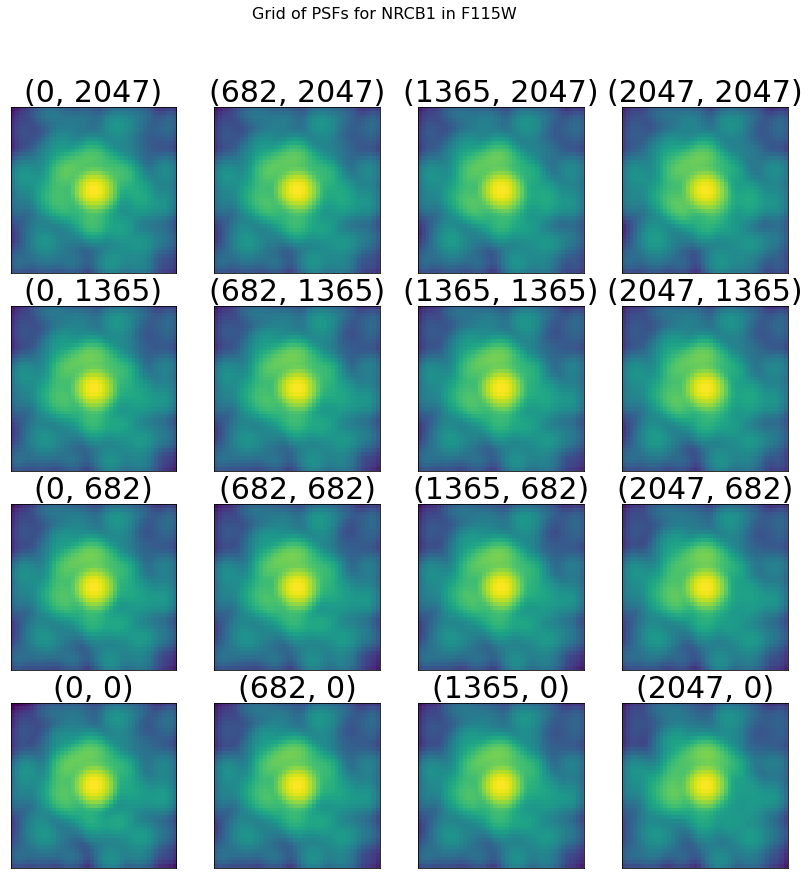

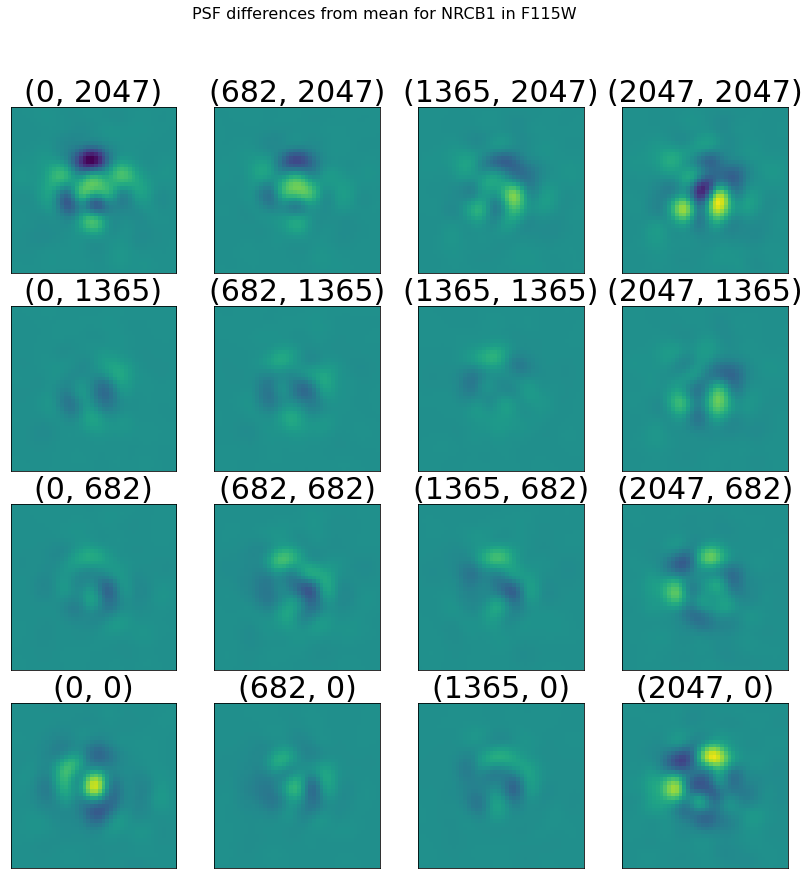

In [30]:
webbpsf.gridded_library.display_psf_grid(psf_webbpsf_grid, zoom_in=False, figsize=(14, 14))

5.<font color='white'>-</font>Create PSF model building an effective PSF<a class="anchor" id="epsf_intro"></a>
------------------

More information on the PhotUtils Effective PSF can be found [here](https://photutils.readthedocs.io/en/stable/epsf.html).

The process of creating an effective PSF can be summarized as follows:

* Find the stars in the image.
* Select the stars we want to use for building the effective PSF. 
* Build the effective PSF.

### 5.1<font color='white'>-</font>Calculate the background<a class="anchor" id="bkg"></a> ###

We adopted as Background estimator the function [MMMBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MMMBackground.html#photutils.background.MMMBackground), which calculates the background in an array using the DAOPHOT MMM algorithm, on the whole image (The background is calculated using a mode estimator of the form `(3 * median) - (2 * mean)`). 

When dealing with a variable background and/or the need to mask the regions where we have no data (for example, if we are analyzing an image with all the 4 NIRCam SW detectors, i.e. containing the chip gaps), we can set `var_bkg = True` and use a more complex algorithm that takes into account those issues.

In [31]:
def calc_bkg(var_bkg=False):
    
    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()

    if var_bkg:
        print('Using 2D Background')
        sigma_clip = SigmaClip(sigma=3.)
        coverage_mask = (data == 0)

        bkg = Background2D(data, (100, 100), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                           coverage_mask=coverage_mask, fill_value=0.0)

        data_bkgsub = data.copy()
        data_bkgsub = data_bkgsub - bkg.background

        _, _, std = sigma_clipped_stats(data_bkgsub)

    else:

        std = bkgrms(data)
        bkg = mmm_bkg(data)

        data_bkgsub = data.copy()
        data_bkgsub -= bkg

    return data_bkgsub, std

### 5.2<font color='white'>-</font>Find sources in the image<a class="anchor" id="find"></a> ###

To find sources in the image, we use the [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) function. 

[DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) detects stars in an image using the DAOFIND ([Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)) algorithm. DAOFIND searches images for local density maxima that have a peak amplitude greater than `threshold` (approximately; threshold is applied to a convolved image) and have a size and shape similar to the defined 2D Gaussian kernel.

**Important parameters**:

* `threshold`: The absolute image value above which to select sources.
* `fwhm`: The full-width half-maximum (FWHM) of the major axis of the Gaussian kernel in units of pixels.

In [32]:
def find_stars(det='NRCA1', filt='F070W', threshold=10, var_bkg=False):
    
    print('Finding stars --- Detector: {d}, Filter: {f}'.format(f=filt, d=det))
    
    sigma_psf = dict_utils[filt]['psf fwhm']

    print('FWHM for the filter {f}:'.format(f=filt), sigma_psf, "px")
    
    data_bkgsub, std = calc_bkg(var_bkg=False)
    
    daofind = DAOStarFinder(threshold=threshold * std, fwhm=sigma_psf)
    found_stars = daofind(data_bkgsub)
    
    print('')
    print('Number of sources found in the image:', len(found_stars))
    print('-------------------------------------')
    print('')
    
    return found_stars

In [33]:
tic = time.perf_counter()

found_stars = find_stars(det=det, filt=filt, threshold=10)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

Finding stars --- Detector: NRCB1, Filter: F115W
FWHM for the filter F115W: 1.298 px

Number of sources found in the image: 8187
-------------------------------------

Elapsed Time for finding stars: 6.985844896000344


### 5.3<font color='white'>-</font>Select sources<a class="anchor" id="select"></a> ###

We can adopt different methods to select sources we want to use to build an effective PSF. Here, we select objects applying a brightness cut (we do not want to include objects that are too faint) and using the `roundness2` and `sharpness` parameters provided in the [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) output catalog.

`roundness2` measures the ratio of the difference in the height of the best fitting Gaussian function in x minus the best fitting Gaussian function in y, divided by the average of the best fitting Gaussian functions in x and y.

`sharpness` measures the ratio of the difference between the height of the central pixel and the mean of the surrounding non-bad pixels in the convolved image, to the height of the best fitting Gaussian function at that point.

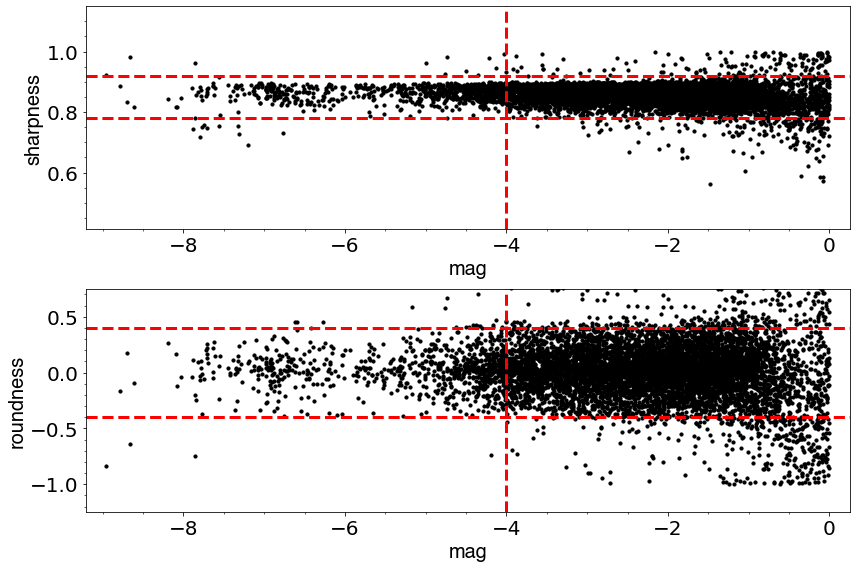

In [34]:
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag', fontdict=font2)
ax1.set_ylabel('sharpness', fontdict=font2)

xlim0 = np.min(found_stars['mag']) - 0.25
xlim1 = np.max(found_stars['mag']) + 0.25
ylim0 = np.min(found_stars['sharpness']) -0.15
ylim1 = np.max(found_stars['sharpness']) +0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')

sh_inf = 0.78
sh_sup = 0.92
mag_lim = -4.0

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([mag_lim, mag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag', fontdict=font2)
ax2.set_ylabel('roundness', fontdict=font2)

ylim0 = np.min(found_stars['roundness2']) -0.25
ylim1 = np.max(found_stars['roundness2']) -0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

round_inf = -0.40
round_sup = 0.40

ax2.scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')
ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([mag_lim, mag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

### 5.4<font color='white'>-</font>Create catalog of selected sources<a class="anchor" id="create_cat"></a> ###

We can also include a separation criteria if we want to retain in the final catalog only the stars that are well isolated. In particular, we can select only the stars that do not have a neighbour closer than X pixel, where X is a parameter that can be set manually.

**Note**: The magnitude limit and the minimum distance to the closest neighbour depend on the user science case (i.e.; number of stars in the field of view, crowding, number of bright sources, minimum number of stars required to build the ePSF, etc.) and must be modified accordingly.

In [35]:
mask = ((found_stars['mag'] < mag_lim) & (found_stars['roundness2'] > round_inf) & 
        (found_stars['roundness2'] < round_sup) & (found_stars['sharpness'] > sh_inf) 
        & (found_stars['sharpness'] < sh_sup))

found_stars_sel = found_stars[mask]

print('Number of stars selected to build ePSF:', len(found_stars_sel))

# if we include the separation criteria:

d = []

# we do not want any stars in a 10 px radius. 

min_sep = 10

x_tot = found_stars['xcentroid']
y_tot = found_stars['ycentroid']

for xx, yy in zip(found_stars_sel['xcentroid'], found_stars_sel['ycentroid']):

    sep = []
    dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2)
    sep = np.sort(dist)[1:2][0]
    d.append(sep)

found_stars_sel['min distance'] = d
mask_dist = (found_stars_sel['min distance'] > min_sep)

found_stars_sel2 = found_stars_sel[mask_dist]

print('Number of stars selected to build ePSF \
including "mimimum distance closest neighbour" selection):', len(found_stars_sel2))

Number of stars selected to build ePSF: 851
Number of stars selected to build ePSF including "mimimum distance closest neighbour" selection): 659


### 5.4<font color='white'>-</font>Build the effective PSF<a class="anchor" id="build_epsf"></a> ###

We Build the effective PSF using [EPSBuilder](https://photutils.readthedocs.io/en/stable/api/photutils.psf.EPSFBuilder.html#photutils.psf.EPSFBuilder) function.

First, we exclude the objects for which the bounding box exceed the detector edge. Then, we extract cutouts of the stars using the [extract_stars()](https://photutils.readthedocs.io/en/stable/api/photutils.psf.extract_stars.html#photutils.psf.extract_stars) function. The size of the cutout is determined by the parameter `size` in our function *build_epsf*. Once we have the object containing the cutouts of our selected stars, we can build our ePSF using [EPSFBuilder](https://photutils.readthedocs.io/en/stable/api/photutils.psf.EPSFBuilder.html#photutils.psf.EPSFBuilder) class. 


<div class="alert alert-block alert-info">

Here we limit the maximum number of iterations to 3 (to limit it’s run time), but in practice one should use about 10 or more iterations.
    
<div >

In [36]:
def build_epsf(det='NRCA1', filt='F070W', size=11, found_table=None, oversample=4, iters=3):
    
    hsize = (size - 1) / 2
    
    x = found_table['xcentroid']
    y = found_table['ycentroid']
    
    mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) & (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
    
    data_bkgsub, _ = calc_bkg()
    
    nddata = NDData(data=data_bkgsub)
    stars = extract_stars(nddata, stars_tbl, size=size)

    print('Creating ePSF --- Detector {d}, filter {f}'.format(f=filt, d=det))

    epsf_builder = EPSFBuilder(oversampling=oversample, maxiters=iters, progress_bar=True)

    epsf, fitted_stars = epsf_builder(stars)
    
    return epsf

In [37]:
epsf = build_epsf(det=det, filt=filt, size=11, found_table=found_stars_sel, oversample=4, iters=3)

Creating ePSF --- Detector NRCB1, filter F115W


### 5.4<font color='white'>-</font>Display the effective PSF<a class="anchor" id="display_epsf"></a> ###

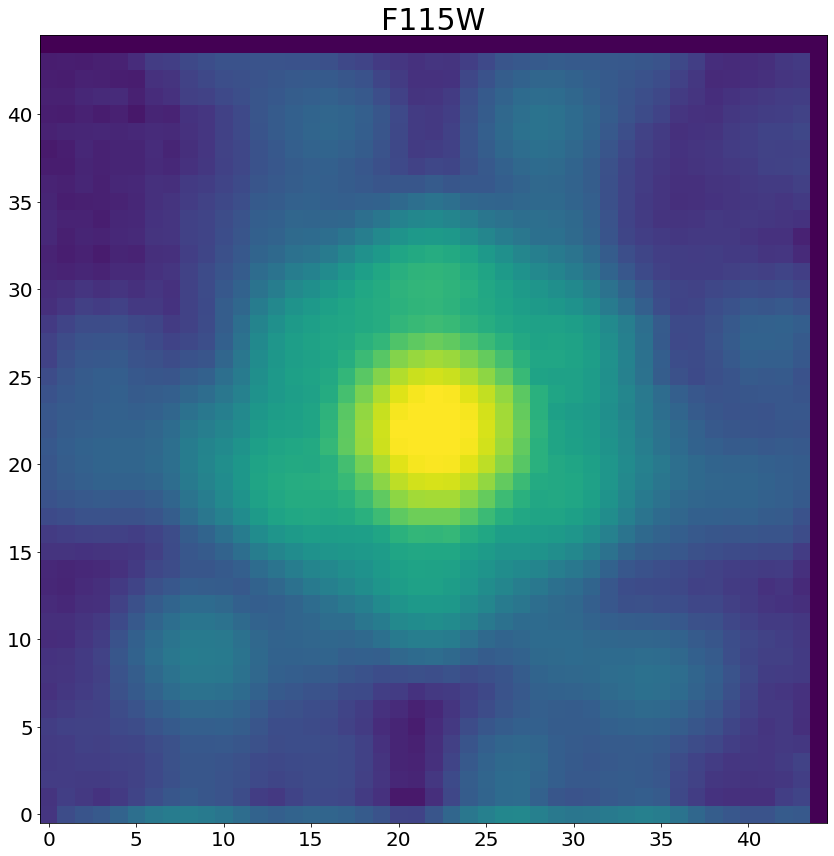

In [38]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(1, 1, 1)

norm_epsf = simple_norm(epsf.data, 'log', percent=99.)
plt.title(filt, fontsize=30)
ax.imshow(epsf.data, norm=norm_epsf)
plt.tight_layout()

6.<font color='white'>-</font>Perform PSF Photometry<a class="anchor" id="psf_phot"></a>
------------------

For general information on PSF Photometry with PhotUtils see [here](https://photutils.readthedocs.io/en/stable/psf.html). 

Photutils provides three classes to perform PSF Photometry: [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), [IterativelySubtractedPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IterativelySubtractedPSFPhotometry.html#photutils.psf.IterativelySubtractedPSFPhotometry), and [DAOPhotPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOPhotPSFPhotometry.html#photutils.psf.DAOPhotPSFPhotometry). Together these provide the core workflow to make photometric measurements given an appropriate PSF (or other) model.

[BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry) implements the minimum tools for model-fitting photometry. At its core, this involves finding sources in an image, grouping overlapping sources into a single model, fitting the model to the sources, and subtracting the models from the image. In DAOPHOT parlance, this is essentially running the “FIND, GROUP, NSTAR, SUBTRACT” once.

[IterativelySubtractedPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IterativelySubtractedPSFPhotometry.html#photutils.psf.IterativelySubtractedPSFPhotometry) (adopted here) is similar to [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), but it adds a parameter called `n_iters` which is the number of iterations for which the loop “FIND, GROUP, NSTAR, SUBTRACT, FIND…” will be performed. This class enables photometry in a scenario where there exists significant overlap between stars that are of quite different brightness. For instance, the detection algorithm may not be able to detect a faint and bright star very close together in the first iteration, but they will be detected in the next iteration after the brighter stars have been fit and subtracted. Like [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), it does not include implementations of the stages of this process, but it provides the structure in which those stages run.

**Important parameters**:

* `finder`: classes to find stars in the image. We use [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html).

* `group_maker`:  clustering algorithm in order to label the sources according to groups. We use [DAOGroup](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup). The method group_stars divides an entire starlist into sets of distinct, self-contained groups of mutually overlapping stars. It accepts as input a list of stars and determines which stars are close enough to be capable of adversely influencing each others’ profile fits. [DAOGroup](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup) aceepts one parameter, `crit_separation`, which is the distance, in units of pixels, such that any two stars separated by less than this distance will be placed in the same group.

* `fitter`: algorithm to fit the sources simultaneously for each group. We use an astropy fitter, [LevMarLSQFitter](https://docs.astropy.org/en/stable/api/astropy.modeling.fitting.LevMarLSQFitter.html#astropy.modeling.fitting.LevMarLSQFitter). 

* `niters`: number of iterations for which the "psf photometry" loop described above is performed.

* `fitshape`: Rectangular shape around the center of a star which will be used to collect the data to do the fitting. 

* `aperture_radius`: The radius (in units of pixels) used to compute initial estimates for the fluxes of sources.

In [47]:
def psf_phot(data=None, det='NRCA1', filt='F070W', th=2000, psf=None, ap_radius=3.5, save_residuals=False, save_output=False):

    fitter = LevMarLSQFitter()
    mmm_bkg = MMMBackground()
        
    sigma_psf = dict_utils[filt]['psf fwhm']
    print('FWHM for filter {f}:'.format(f=filt), sigma_psf)
    
    _,std = calc_bkg()
    
    daofind = DAOStarFinder(threshold=th * std, fwhm=sigma_psf)
    
    daogroup = DAOGroup(5.0 * sigma_psf)
    
    psf_model = psf.copy()
    
    print('Performing the PSF photometry --- Detector {d}, filter {f}'.format(f=filt, d=det))
            
    tic = time.perf_counter()
    
    phot = IterativelySubtractedPSFPhotometry(finder=daofind, group_maker=daogroup,
                                              bkg_estimator=mmm_bkg, psf_model=psf_model,
                                              fitter=LevMarLSQFitter(),
                                              niters=2, fitshape=(11, 11), aperture_radius=ap_radius, 
                                              extra_output_cols=('sharpness', 'roundness2'))
    result = phot(data)
    
    toc = time.perf_counter()
    
    print('Time needed to perform photometry:', '%.2f' % ((toc - tic) / 3600), 'hours')
    print('Number of sources detected:', len(result))
        
    residual_image = phot.get_residual_image()
    
    # save the residual images as fits file:

    if save_residuals:
        hdu = fits.PrimaryHDU(residual_image)
        hdul = fits.HDUList([hdu])
    
        residual_outname = 'residual_%s_%s.fits' % (det, filt)

        hdul.writeto(os.path.join(res_dir, residual_outname))


    # save the output photometry Tables

    if save_output:

        outname = 'phot_%s_%s.pkl' % (det, filt)
        
        tab = result.to_pandas()
        tab.to_pickle(os.path.join(output_phot_dir, outname))
    
    return result, residual_image

In [48]:
# During the Webbinar we use a cutout of the whole image to speed up the reduction process

data1 = data[0:500,0:500]
#data1 = data

output_phot_dir = 'PHOT_OUTPUT/'

if not os.path.exists(output_phot_dir):
    os.makedirs(output_phot_dir)

res_dir = 'RESIDUAL_IMAGES/'

if not os.path.exists(res_dir):
    os.makedirs(res_dir)

if glob.glob(os.path.join(res_dir, 'residual*.fits')):
    print('Deleting Residual images from directory')
    files = glob.glob(os.path.join(res_dir, 'residual*.fits')
    for file in files:
        os.remove(file)

psf_phot_results, residual_image = psf_phot(data=data1, det=det, filt=filt, th=10, psf=psf_webbpsf_grid, 
                                            save_residuals=True, save_output=True)

FWHM for filter F115W: 1.298
Performing the PSF photometry --- Detector NRCB1, filter F115W


Time needed to perform photometry: 0.01 hours
Number of sources detected: 647


### 6.1<font color='white'>-</font>PSF photometry output catalog<a class="anchor" id="psf_cat"></a> ###

In [49]:
psf_phot_results

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,sharpness,roundness2,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,int64
111.4549521755245,111.63995880622012,6.15437250521313,6.132232705553136,74.09914225567421,116.23243277806314,1,0.8643535840036736,-0.16817050251553944,1,1.3673558694750925,0.009997454585539967,0.012286657470918514,1
476.54242479321977,476.35959252487595,6.650514839010262,6.416726127022777,34.43919898321262,56.51291716305828,2,0.8261658773117586,0.0802264267670919,2,0.8583246483194087,0.01270525076343188,0.012727961599865655,1
20.854750922553933,20.883848838918002,7.245861954545824,7.19495705978904,130.85700276103464,210.40980605304364,3,0.8865591549978297,0.05613499747311773,3,2.452358359565746,0.012244536866533649,0.011424595477943904,1
302.68847674935637,302.7715294260232,7.388348438195823,7.284405049418346,7.780765123297631,12.46666695371725,4,0.870409008899391,0.13333745799782037,4,0.29796250608858216,0.022969850127557118,0.021774360302239906,1
163.67427817261938,163.761673771063,8.676651399275041,8.419568053007547,47.33912925326444,73.10117090147162,5,0.8484224230749726,0.21353606115775228,5,0.8303603877645137,0.010755745409022546,0.009507529019602643,1
178.8618967577932,178.8961928759287,8.841208390631946,8.876217300040917,49.66127884933111,72.5389954154438,6,0.8936851912113427,0.03583709041401492,6,0.8966789820510579,0.013153525883761502,0.013308988354648365,1
440.5349186682201,440.68360453649746,8.62133163995493,8.734477916285448,9.007334835546477,13.697202491368559,7,0.872974129217482,-0.041601368548198306,7,0.23810200673126888,0.015459963440665204,0.016606598230432836,1
75.70588276834653,75.77563064958412,13.676603397104973,13.417684691583272,26.355901479611312,41.31109115755396,8,0.8510434730632017,0.2301153094477069,8,0.487079309098908,0.011262923429192455,0.009857156515089343,1
485.32510530008597,485.2417962271745,13.890400061005376,13.504606799219395,10.924502006116494,15.62898159732197,9,0.8295168929452126,0.383505327494363,9,0.28701541165203764,0.016797685965692342,0.01519615548201645,1


### 6.2<font color='white'>-</font>Display residual image<a class="anchor" id="residual"></a> ###

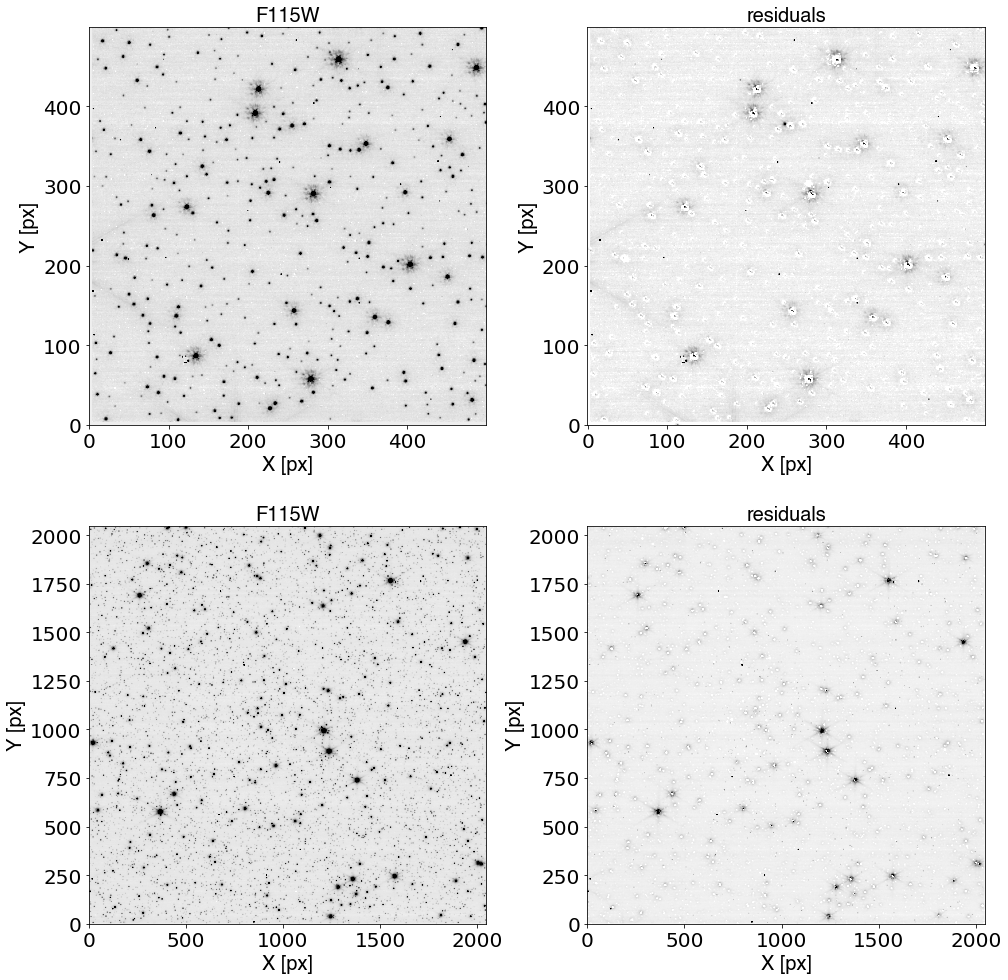

In [56]:
plt.figure(figsize=(14, 14))

ax1 = plt.subplot(2, 2, 1)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title(filt, fontdict=font2)

norm = simple_norm(data1, 'sqrt', percent=99.)
ax1.imshow(data1, norm=norm, cmap='Greys')

ax2 = plt.subplot(2, 2, 2)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title('residuals', fontdict=font2)

norm = simple_norm(data1, 'sqrt', percent=99.)
ax2.imshow(residual_image, norm=norm, cmap='Greys')

ax3 = plt.subplot(2, 2, 3)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title(filt, fontdict=font2)

norm = simple_norm(data, 'sqrt', percent=99.)
ax3.imshow(data, norm=norm, cmap='Greys')

ax4 = plt.subplot(2, 2, 4)

if os.path.isfile('./residual_webbpsf_grid16_NRCB1_F115W.fits'):
    res_f115w = './residual_webbpsf_grid16_NRCB1_F115W.fits'

else:
    print('Downloading F115W residual image')
    
    boxlink_res_f115w = 'https://stsci.box.com/shared/static/g4ffi7zowwlj91up4nkqxz38c1l4tpjx.fits'
    boxfile_res_f115w = './residual_webbpsf_grid16_NRCB1_F115W.fits'
    urllib.request.urlretrieve(boxlink_res_f115w, boxfile_res_f115w)
    res_f115w = boxfile_res_f115w

if os.path.isfile('./residual_webbpsf_grid16_NRCB1_F200W.fits'):
    res_f200w = './residual_webbpsf_grid16_NRCB1_F200W.fits'

else:
    print('Downloading F200W residual image')
    
    boxlink_res_f200w = 'https://stsci.box.com/shared/static/mssn25cokiwfwco9f289nds7lennfgvv.fits'
    boxfile_res_f200w = './residual_webbpsf_grid16_NRCB1_F200W.fits'
    urllib.request.urlretrieve(boxlink_res_f200w, boxfile_res_f200w)
    res_f200w = boxfile_res_f200w

residual = res_f115w

residual = fits.open('./residual_webbpsf_grid16_NRCB1_F115W.fits')
res_data = residual[0].data

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title('residuals', fontdict=font2)

ax4.imshow(res_data, norm=norm, cmap='Greys')

plt.tight_layout()

7.<font color='white'>-</font>Bonus part I: create your first NIRCam Color-Magnitude Diagram <a class="anchor" id="bonusI"></a>
------------------

### 7.1<font color='white'>-</font>Load images and output catalogs<a class="anchor" id="load_data"></a> ###

In [58]:
if os.path.isfile('./phot_webbpsf_grid16_NRCB1_F115W.pkl'):
    phot_f115w = './phot_webbpsf_grid16_NRCB1_F115W.pkl'

else:
    print('Downloading F115W PSF photometry')
    
    boxlink_ph_f115w = 'https://stsci.box.com/shared/static/f4s4ziwh7tb3827g0ac362swwta28lti.pkl'
    boxfile_ph_f115w = './phot_webbpsf_grid16_NRCB1_F115W.pkl'
    urllib.request.urlretrieve(boxlink_ph_f115w, boxfile_ph_f115w)
    phot_f115w = boxfile_ph_f115w

if os.path.isfile('./phot_webbpsf_grid16_NRCB1_F200W.pkl'):
    phot_f200w = './phot_webbpsf_grid16_NRCB1_F200W.pkl'

else:
    print('Downloading F200W PSF Photometry')
    
    boxlink_ph_f200w = 'https://stsci.box.com/shared/static/983dxnxqz594ogn00e6m7ek7vq22gifr.pkl'
    boxfile_ph_f200w = './phot_webbpsf_grid16_NRCB1_F200W.pkl'
    urllib.request.urlretrieve(boxlink_ph_f200w, boxfile_ph_f200w)
    phot_f200w = boxfile_ph_f200w


ph_f115w = pd.read_pickle(phot_f115w)
ph_f200w = pd.read_pickle(phot_f200w)

results_f115w = QTable.from_pandas(ph_f115w)
results_f200w = QTable.from_pandas(ph_f200w)

image_f115w = ImageModel('./jw00042001001_01101_00001_nrcb1_cal.fits')
image_f200w = ImageModel('./jw00042001001_01101_00005_nrcb1_cal.fits')

### 7.2<font color='white'>-</font>Cross-match PSF photometry catalogs<a class="anchor" id="cross_match"></a> ###

We select only stars with positive flux and we use the information from the image WCS to transform detector coordinates (x,y) to celestial coordinate (RA,Dec). 

We use the [SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) class and the [match_coordinates_sky](https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html) function to finds the nearest on-sky matches between the set of catalog coordinates.

We impose that a star is the same in both catalogs if the separation is < than `max_sep`, where `max_sep` is 0.015 arcsec (i.e., 0.5 px). 

In [59]:
mask_f115w = ((results_f115w['x_fit'] > 0) & (results_f115w['x_fit'] < 2048) & 
              (results_f115w['y_fit'] > 0) & (results_f115w['y_fit'] < 2048) & 
              (results_f115w['flux_fit'] > 0))

result_clean_f115w = results_f115w[mask_f115w]

ra_f115w, dec_f115w = image_f115w.meta.wcs(result_clean_f115w['x_fit'], result_clean_f115w['y_fit'])
radec_f115w = SkyCoord(ra_f115w, dec_f115w, unit='deg')
result_clean_f115w['radec'] = radec_f115w

mask_f200w = ((results_f200w['x_fit'] > 0) & (results_f200w['x_fit'] < 2048) & 
              (results_f200w['y_fit'] > 0) & (results_f200w['y_fit'] < 2048) & 
              (results_f200w['flux_fit'] > 0))

result_clean_f200w = results_f200w[mask_f200w]

ra_f200w, dec_f200w = image_f200w.meta.wcs(result_clean_f200w['x_fit'], result_clean_f200w['y_fit'])
radec_f200w = SkyCoord(ra_f200w, dec_f200w, unit='deg')

result_clean_f200w['radec'] = radec_f200w

In [60]:
max_sep = 0.015 * u.arcsec

filt1 = 'F115W'
filt2 = 'F200W'

res1 = result_clean_f115w
res2 = result_clean_f200w

idx, d2d, _ = match_coordinates_sky(res1['radec'], res2['radec'])

sep_constraint = d2d < max_sep

match_phot_single = Table()

x_0_f115w = res1['x_0'][sep_constraint]
y_0_f115w = res1['y_0'][sep_constraint]
x_fit_f115w = res1['x_fit'][sep_constraint]
y_fit_f115w = res1['y_fit'][sep_constraint]
radec_f115w = res1['radec'][sep_constraint]
mag_f115w = (-2.5 * np.log10(res1['flux_fit']))[sep_constraint]
emag_f115w = (1.086 * (res1['flux_unc'] / res1['flux_fit']))[sep_constraint]

x_0_f200w = res2['x_0'][idx[sep_constraint]]
y_0_f200w = res2['y_0'][idx[sep_constraint]]
x_fit_f200w = res2['x_fit'][idx[sep_constraint]]
y_fit_f200w = res2['y_fit'][idx[sep_constraint]]
radec_f200w = res2['radec'][idx][sep_constraint]
mag_f200w = (-2.5 * np.log10(res2['flux_fit']))[idx[sep_constraint]]
emag_f200w = (1.086 * (res2['flux_unc'] / res2['flux_fit']))[idx[sep_constraint]]

match_phot_single['x_0_' + filt1] = x_0_f115w
match_phot_single['y_0_' + filt1] = y_0_f115w
match_phot_single['x_fit_' + filt1] = x_fit_f115w
match_phot_single['y_fit_' + filt1] = y_fit_f115w
match_phot_single['radec_' + filt1] = radec_f115w
match_phot_single['mag_' + filt1] = mag_f115w
match_phot_single['emag_' + filt1] = emag_f115w
match_phot_single['x_0_' + filt2] = x_0_f200w
match_phot_single['y_0_' + filt2] = y_0_f200w
match_phot_single['x_fit_' + filt2] = x_fit_f200w
match_phot_single['y_fit_' + filt2] = y_fit_f200w
match_phot_single['radec_' + filt2] = radec_f200w
match_phot_single['mag_' + filt2] = mag_f200w
match_phot_single['emag_' + filt2] = emag_f200w

print('Number of sources in common between the two filters:', len(match_phot_single)) 

Number of sources in common between the two filters: 7226


### 7.3<font color='white'>-</font>Load input catalogs<a class="anchor" id="load_input"></a> ###

In [62]:
if os.path.isfile('./jw00042001001_01101_00001_nrcb1_uncal_pointsources.list'):
    input_catalog_f115w = './jw00042001001_01101_00001_nrcb1_uncal_pointsources.list'

else:
    print('Downloading F115W input catalog photometry')
    
    boxlink_inpcat_f115w = 'https://stsci.box.com/shared/static/1qdcq418fcmeekkzlw8uqmbz1656t3kd.list'
    boxfile_inpcat_f115w = './jw00042001001_01101_00001_nrcb1_uncal_pointsources.list'
    urllib.request.urlretrieve(boxlink_inpcat_f115w, boxfile_inpcat_f115w)
    input_catalog_f115w = boxfile_inpcat_f115w


if os.path.isfile('./jw00042001001_01101_00005_nrcb1_uncal_pointsources.list'):
    input_catalog_f200w = './jw00042001001_01101_00005_nrcb1_uncal_pointsources.list'

else:
    print('Downloading F200W input catalog photometry')
    
    boxlink_inpcat_f200w = 'https://stsci.box.com/shared/static/saeqibfbeccpv5gt9ndlb826o68ikt4b.list'
    boxfile_inpcat_f200w = './jw00042001001_01101_00005_nrcb1_uncal_pointsources.list'
    urllib.request.urlretrieve(boxlink_inpcat_f200w, boxfile_inpcat_f200w)
    input_catalog_f200w = boxfile_inpcat_f200w

input_cat_f115w = pd.read_csv(input_catalog_f115w, header=None, sep='\s+', 
                              names=['index', 'ra_in', 'dec_in', 'f115w_in'], 
                              comment='#', skiprows=2, usecols=(0, 3, 4, 7))


input_cat_f200w = pd.read_csv(input_catalog_f200w, header=None, sep='\s+', 
                              names=['index', 'ra_in', 'dec_in', 'f200w_in'], 
                              comment='#', skiprows=2, usecols=(0, 3, 4, 7))


input_cat_f200w.head()

,index,ra_in,dec_in,f200w_in
0,113210,80.481668,-69.497006,21.642
1,113211,80.479452,-69.497006,21.217
2,113289,80.484279,-69.496980,22.061
3,113290,80.475302,-69.496978,20.669
4,113424,80.484946,-69.496943,22.251


### 7.4<font color='white'>-</font>Cross-match input catalogs<a class="anchor" id="cross_match_input"></a> ###

In [63]:
radec_input_f115w = SkyCoord(input_cat_f115w['ra_in'], input_cat_f115w['dec_in'], unit='deg')
radec_input_f200w = SkyCoord(input_cat_f200w['ra_in'], input_cat_f200w['dec_in'], unit='deg')

idx_inp, d2d_inp, _ = match_coordinates_sky(radec_input_f115w, radec_input_f200w)

max_sep = 0.015 * u.arcsec

sep_constraint_inp = d2d_inp < max_sep

f115w_inp = input_cat_f115w['f115w_in'][sep_constraint_inp]
f200w_inp = input_cat_f200w['f200w_in'][idx_inp[sep_constraint_inp]]

### 7.5<font color='white'>-</font>Instrumental Color-Magnitude Diagram<a class="anchor" id="cmd"></a> ###

We compare the input (calibrated) color-magnitude diagram (CMD) with the instrumental CMD retrieved from the PSF photometry analysis. To obtain a calibrated final color-magnitude diagram, we need to derive the photometric zeropoints for the ouput catalogs (not covered in this JWebbinar).

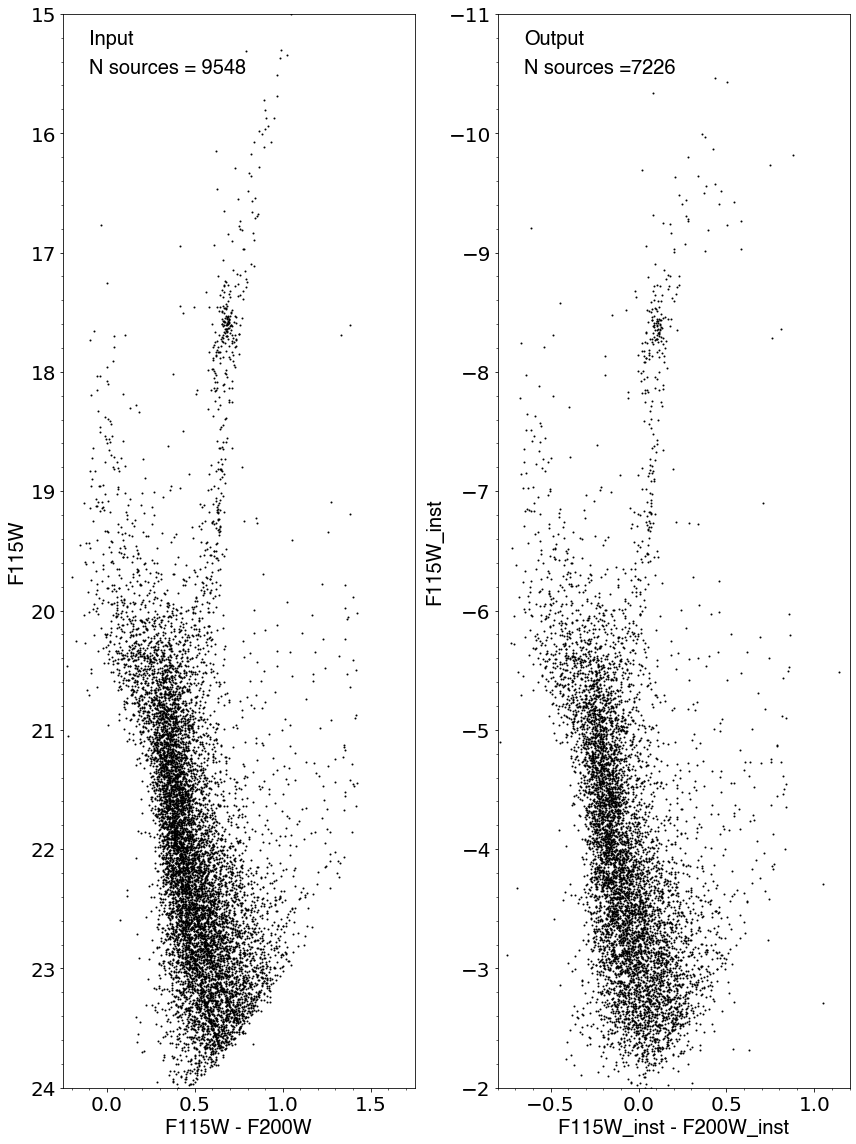

In [64]:
plt.figure(figsize=(12, 16))
plt.clf()

ax1 = plt.subplot(1,2,1)

xlim0 = -0.25 
xlim1 = 1.75 
ylim0 = 24
ylim1 = 15 

ax1.set_xlim(xlim0,xlim1)
ax1.set_ylim(ylim0,ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(f115w_inp - f200w_inp, f115w_inp, s = 1, color = 'k')

ax1.set_xlabel(filt1+' - '+filt2, fontdict = font2)
ax1.set_ylabel(filt1, fontdict = font2)
ax1.text(xlim0+0.15, ylim1+0.25, 'Input', fontdict = font2)
ax1.text(xlim0+0.15, ylim1+0.50, 'N sources = '+ str(len(f115w_inp)), fontdict = font2)

ax2 = plt.subplot(1, 2, 2)

xlim0 = -0.8
xlim1 = 1.2
ylim0 = -2
ylim1 = -11

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

f115w_single = match_phot_single['mag_' + filt1]
f200w_single = match_phot_single['mag_' + filt2]

ax2.scatter(f115w_single - f200w_single, f115w_single, s=1, color='k')

ax2.set_xlabel(filt1 + '_inst - ' + filt2 +'_inst', fontdict=font2)
ax2.set_ylabel(filt1 + '_inst', fontdict=font2)
ax2.text(xlim0+0.15, ylim1+0.25, 'Output', fontdict = font2)
ax2.text(xlim0+0.15, ylim1+0.50, 'N sources ='+ str(len(f115w_single)), fontdict = font2)


plt.tight_layout()

8.<font color='white'>-</font>Bonus part II: create a grid of empirical PSFs <a class="anchor" id="bonusII"></a>
------------------

### 8.1<font color='white'>-</font>Count stars in N x N grid<a class="anchor" id="count_stars"></a> ###

The purpose of the function `count_stars_grid` is to count how many good PSF stars are in cell of a N x N grid. The function starts from  a grid of size N x N (where N = sqrt(**num_psfs**)) and iterate until the minimum grid size 2 x 2. Depending on the number of PSF stars that the users want in each cell of the grid, they can choose the appropriate grid size or modify the threshold values and/or the selection parameters adopted during the stars detection, in Sections 5.3, 5.4. 

The minimum number of PSF stars needed in each cell can also be set using the parameter **min_numpsfs_stars**. Useful when inspecting the plot, since in the cells with a number of PSF stars < **min_numpsfs_stars**, the value is reported in RED. Moreover, when `verbose = True`, it is easier to identify for each N x N combination, if and which cells have not enough PSF stars.

This function returns sqrt(**num_psfs**) - 1 figures showing the number of PSFs stars in each cell for all the N x N combination.

In [65]:
def find_centers(num):
    points = int(((data.shape[0] / num) / 2) - 1)
    x_center = np.arange(points, 2 * points * num, 2 * points)
    y_center = np.arange(points, 2 * points * num, 2 * points)

    centers = np.array(np.meshgrid(x_center, y_center)).T.reshape(-1, 2)

    return points, centers

def count_stars_grid(num_psfs=4, min_numpsf_stars=40, size=11, verbose=True, savefig=True):
    
    # calculate the number of stars from find_stars in each cell of the grid. The maximum number of cell
    # is defined by num_psfs and the function iterate from N x N (where N = sqrt(num_psfs)) until a 2 x 2 grid.

    if np.sqrt(num_psfs).is_integer():
        grid_points = int(np.sqrt(num_psfs))

    else:
        raise ValueError("You must choose a square number of cells to create (E.g. 9, 16, etc.)")

    num_grid = np.arange(2, grid_points + 1, 1)
    num_grid = num_grid[::-1]


    for num in num_grid:
        print("--------------------")
        print("")
        print("Calculating the number of PSF stars in a %d x %d grid:" % (num, num))
        print("")

        s = (data.shape[1], data.shape[0])
        temp_arr = np.zeros(s)
        num_psfs_stars = []

        points, centers = find_centers(num)

        for n, val in enumerate(centers):

            x = found_stars_sel['xcentroid']
            y = found_stars_sel['ycentroid']

            half_size = (size - 1) / 2

            lim1 = int(val[0] - points + half_size)
            lim2 = int(val[0] + points - half_size)
            lim3 = int(val[1] - points + half_size)
            lim4 = int(val[1] + points - half_size)

            number_psf_stars = (x > lim1) & (x < lim2) & (y > lim3) & (y < lim4)
            count_psfs_stars = np.count_nonzero(number_psf_stars)

            lim_x1 = int(lim1 - half_size)
            lim_x2 = int(lim2 + half_size)
            lim_y1 = int(lim3 - half_size)
            lim_y2 = int(lim4 + half_size)

            if verbose:

                if np.count_nonzero(number_psf_stars) < min_numpsf_stars:
                    print('Center Coordinates of grid cell {:d} are ({:d}, {:d}) --- Not enough stars in the cell '
                            '(number of stars < {:d})'.format(n + 1, val[0], val[1], min_numpsf_stars))

                else:
                    print(f'Center Coordinate of grid cell {n + 1:d} are ({val[0]:d}, {val[1]:d})'
                            '--- Number of stars:', np.count_nonzero(number_psf_stars))
                    print("")

            temp_arr[lim_y1:lim_y2, lim_x1:lim_x2] = count_psfs_stars
            num_psfs_stars.append(count_psfs_stars)

        if savefig:
            plot_count_grid(temp_arr, num, num_psfs_stars, centers)

def plot_count_grid(arr, num, nstars, centers):
    
    plt.clf()

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 1, 1)

    plt.xlabel('X [px]', font={'size': 20})
    plt.ylabel('Y [px]', font={'size': 20})
    plt.title('%dx%d grid - ' % (num, num) + det + ' - ' + filt, font={'size': 25})
    im = ax.imshow(arr, origin='lower', vmin=np.min(arr[arr > 0]), vmax=np.max(arr))
    for i in range(num ** 2):
        if nstars[i] < 40:
            ax.text(centers[i][0] - 100, centers[i][1] - 50, "%d" % nstars[i], c='r', font={'size': 30})
        else:
            ax.text(centers[i][0] - 100, centers[i][1] - 50, "%d" % nstars[i], c='w', font={'size': 30})
    ax.text(2300, 750, "# of PSF stars", rotation=270, font={'size': 25})
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.tight_layout()

    filename = 'number_PSFstars_%dx%dgrid_%s_%s.pdf' % (num, num, det, filt)

    plt.savefig(os.path.join(figures_dir, filename))

--------------------

Calculating the number of PSF stars in a 5 x 5 grid:

Center Coordinate of grid cell 1 are (203, 203)--- Number of stars: 45

Center Coordinates of grid cell 2 are (203, 609) --- Not enough stars in the cell (number of stars < 40)
Center Coordinates of grid cell 3 are (203, 1015) --- Not enough stars in the cell (number of stars < 40)
Center Coordinates of grid cell 4 are (203, 1421) --- Not enough stars in the cell (number of stars < 40)
Center Coordinates of grid cell 5 are (203, 1827) --- Not enough stars in the cell (number of stars < 40)
Center Coordinates of grid cell 6 are (609, 203) --- Not enough stars in the cell (number of stars < 40)
Center Coordinates of grid cell 7 are (609, 609) --- Not enough stars in the cell (number of stars < 40)
Center Coordinates of grid cell 8 are (609, 1015) --- Not enough stars in the cell (number of stars < 40)
Center Coordinates of grid cell 9 are (609, 1421) --- Not enough stars in the cell (number of stars < 40)
Center 

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

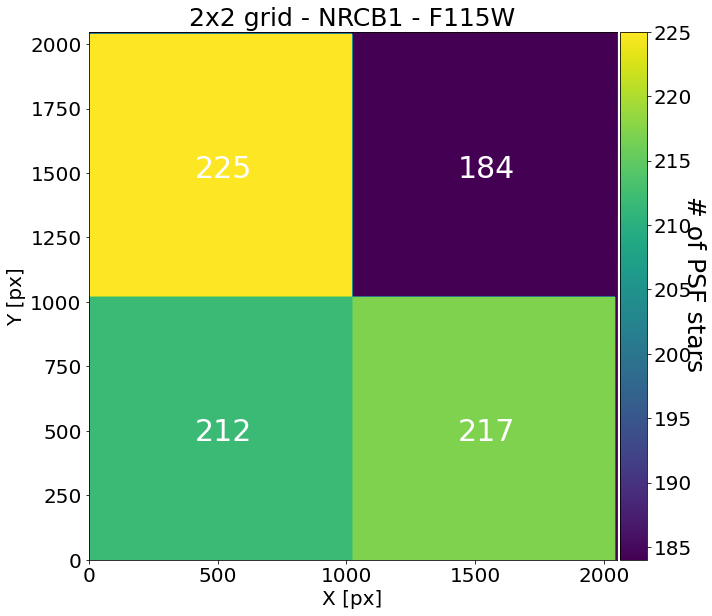

In [66]:
figures_dir = 'FIGURES/'

if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

count_stars_grid(num_psfs=25, min_numpsf_stars=40, size=11, verbose=True, savefig=True)

### 8.2<font color='white'>-</font>Build effective PSF (single or grid)<a class="anchor" id="epsf_grid"></a> ###

This function creates a grid of PSFs with EPSFBuilder (or a single PSF, when **num_psfs**=1). The function returns a GriddedEPSFModel object containing a 3D array of N  ×  n  ×  n. The 3D array represents the N number of 2D n  ×  n ePSFs created. It includes a grid_xypos key which will state the position of the PSF on the detector for each of the PSFs. The order of the tuples in grid_xypos refers to the number the PSF is in the 3D array.

In [67]:
def build_epsf_grid(num_psfs=4, size=11, oversample=4, save=True, savefig=True, overwrite=True):

    if np.sqrt(num_psfs).is_integer():
        num_grid = int(np.sqrt(num_psfs))

    else:
        raise ValueError("You must choose a square number of cells to create (E.g. 9, 16, etc.)")


    points, centers = find_centers(num_grid)

    epsf_size = size * oversample
    epsf_arr = np.empty((num_grid ** 2, epsf_size, epsf_size))

    for i, val in enumerate(centers):

        x = found_stars_sel['xcentroid']
        y = found_stars_sel['ycentroid']

        half_size = (size - 1) / 2

        lim1 = int(val[0] - points + half_size)
        lim2 = int(val[0] + points - half_size)
        lim3 = int(val[1] - points + half_size)
        lim4 = int(val[1] + points - half_size)

        mask = ((x > lim1) & (x < lim2) & (y > lim3) & (y < lim4))

        stars_tbl = Table()
        stars_tbl['x'] = x[mask]
        stars_tbl['y'] = y[mask]
        print('Number of sources in cell %d used to build the ePSF:' % (i + 1), len(stars_tbl['x']))

        nddata = NDData(data=data_bkgsub)
        stars = extract_stars(nddata, stars_tbl, size=size)

        print("Creating ePSF for cell %d - Coordinates (%d, %d)" % (i + 1, val[0], val[1]))
        print("")

        epsf_builder = EPSFBuilder(oversampling=oversample, maxiters=3, progress_bar=False)

        epsf, fitted_stars = epsf_builder(stars)

        epsf_arr[i, :, :] = epsf.data[:epsf.shape[0]-1, 1:epsf.shape[0]]

        meta = OrderedDict()
        meta["DETECTOR"] = (det, "Detector name")
        meta["FILTER"] = (filt, "Filter name")
        meta["NUM_PSFS"] = (num_grid ** 2, "The total number of ePSFs")
        for h, loc in enumerate(centers):
            loc = np.asarray(loc, dtype=float)

            meta["DET_YX{}".format(h)] = (str((loc[1], loc[0])),
                                            "The #{} PSF's (y,x) detector pixel position".format(h))

        meta["OVERSAMP"] = (oversample, "Oversampling Factor in EPSFBuilder")

        model_epsf = create_model(epsf_arr, meta)

    if savefig:
        plot_epsf(model_epsf, num_psfs)

    if save:
        writeto(epsf_arr, meta, num_psfs)

        return model_epsf

def writeto(data, meta, num_psfs, overwrite=True):

    primaryhdu = fits.PrimaryHDU(data)

    # Convert meta dictionary to header
    tuples = [(a, b, c) for (a, (b, c)) in meta.items()]
    primaryhdu.header.extend(tuples)

    # Add extra descriptors for how the file was made
    primaryhdu.header["COMMENT"] = "For a given filter, and detector 1 file is produced in "
    primaryhdu.header["COMMENT"] = "the form [i, y, x] where i is the ePSF position on the detector grid "
    primaryhdu.header["COMMENT"] = "and (y,x) is the 2D PSF. The order of PSFs can be found under the "
    primaryhdu.header["COMMENT"] = "header DET_YX* keywords"

    hdu = fits.HDUList(primaryhdu)

    filename = "epsf_{}_{}_nepsf{}.fits".format(det, filt, num_psfs)
    
    file = os.path.join(psfs_dir, filename)

    hdu.writeto(file, overwrite=overwrite)

def plot_epsf(model, num):

    if num == 1:
        plt.clf()
        plt.figure(figsize=(10, 10))
        ax = plt.subplot(1, 1, 1)

        norm_epsf = simple_norm(model.data[0], 'log', percent=99.)
        plt.suptitle(det + ' - ' + filt, font={'size': 20})
        plt.title(model.meta['grid_xypos'][0], font={'size': 20})
        ax.imshow(model.data[0], norm=norm_epsf)
        plt.tight_layout()

        filename = 'ePSF_single_%s_%s.pdf' % (det, filt)
        
        plt.savefig(os.path.join(figures_dir, filename))
 
    else:
        plt.clf()

        nn = int(np.sqrt(num))
        figsize = (12, 12)
        fig, ax = plt.subplots(nn, nn, figsize=figsize)

        for ix in range(nn):
            for iy in range(nn):
                i = ix * nn + iy
                norm_epsf = simple_norm(model.data[i], 'log', percent=99.)
                ax[nn - 1 - iy, ix].imshow(model.data[i], norm=norm_epsf)
                ax[nn - 1 - iy, ix].set_title(model.meta['grid_xypos'][i], font={'size': 20})

        plt.suptitle(det + ' - ' + filt, font={'size': 40})
        plt.tight_layout()
    
        filename = 'ePSF_%dx%dgrid_%s_%s.pdf' % (nn, nn, det, filt)
        
        plt.savefig(os.path.join(figures_dir, filename))


def create_model(data, meta):

    ndd = NDData(data, meta=meta, copy=True)

    ndd.meta['grid_xypos'] = [((float(ndd.meta[key][0].split(',')[1].split(')')[0])),
                                   (float(ndd.meta[key][0].split(',')[0].split('(')[1]))) for key in ndd.meta.keys() if
                                  "DET_YX" in key]

    ndd.meta['oversampling'] = meta["OVERSAMP"][0]
    ndd.meta = {key.lower(): ndd.meta[key] for key in ndd.meta}
    model = GriddedPSFModel(ndd)

    return model

Number of sources in cell 1 used to build the ePSF: 848
Creating ePSF for cell 1 - Coordinates (1023, 1023)



<Figure size 432x288 with 0 Axes>

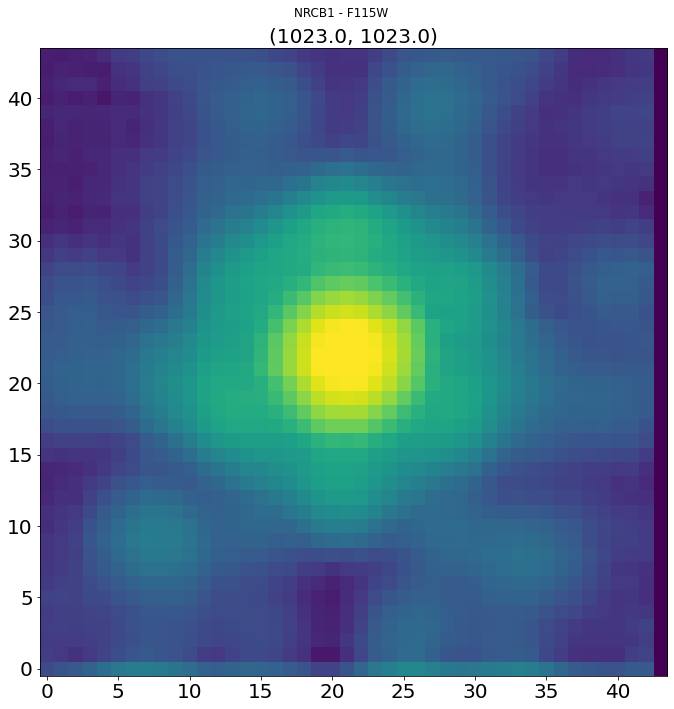

In [71]:
from collections import OrderedDict

psfs_dir = 'PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)
    
data_bkgsub, _ = calc_bkg()

epsf_grid = build_epsf_grid(num_psfs=1, size=11, oversample=4, save=True, savefig=True, overwrite=True)